In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import zipfile
import os

zip_ref = zipfile.ZipFile('/content/drive/MyDrive/archive.zip','r') #Opens the zip file
zip_ref.extractall('/tmp')  #Extracts the files into the /tmp folder
zip_ref.close()

In [4]:
# Import Libraries
import torchvision
import torch.utils.data as utils
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader,Dataset
from torch.autograd import Variable
import matplotlib.pyplot as plt
import torchvision.utils
import numpy as np
import time
import copy
from torch.optim import lr_scheduler
import os
from PIL import Image
import torch
from torch.autograd import Variable
import PIL.ImageOps
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import pandas as pd
from tqdm import tqdm

In [5]:
from PIL import Image

class ResizeWithPadding:
    def __init__(self, size):
        self.size = size  # Target size, e.g., (105, 105)

    def __call__(self, img):
        img = img.convert("L")  # Convert to grayscale
        old_size = img.size  # (width, height)
        ratio = float(self.size[0]) / max(old_size)
        new_size = tuple([int(x * ratio) for x in old_size])
        img = img.resize(new_size, Image.BILINEAR)

        new_img = Image.new("L", self.size, color=255)  # White background
        new_img.paste(img, ((self.size[0] - new_size[0]) // 2,
                            (self.size[1] - new_size[1]) // 2))
        return new_img


In [6]:
def imshow(img,text=None,should_save=False):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

def show_plot(iteration,loss):
    plt.plot(iteration,loss)
    plt.show()

In [7]:
import os

path = "/tmp/sign_data"
files = os.listdir(path)

for f in files:
    print(f)

sign_data
train
test
test_data.csv
train_data.csv


In [8]:
class Config():
    training_dir = "/tmp/sign_data/train"
    testing_dir = "/tmp/sign_data/test"
    train_batch_size = 16
    train_number_epochs = 40

In [9]:
training_dir="/tmp/sign_data/train"
training_csv="/tmp/sign_data/train_data.csv"
testing_csv="/tmp/sign_data/test_data.csv"
testing_dir="/tmp/sign_data/test"

In [10]:
class SiameseNetworkDataset():

    def __init__(self,training_csv=None,training_dir=None,transform=None):
        # used to prepare the labels and images path
        self.training_df=pd.read_csv(training_csv)
        self.training_df.columns =["image1","image2","label"]
        self.training_dir = training_dir
        self.transform = transform

    def __getitem__(self,index):

        # getting the image path
        image1_path=os.path.join(self.training_dir,self.training_df.iat[index,0])
        image2_path=os.path.join(self.training_dir,self.training_df.iat[index,1])


        # Loading the image
        img0 = Image.open(image1_path)
        img1 = Image.open(image2_path)
        img0 = img0.convert("L")
        img1 = img1.convert("L")

        # Apply image transformations
        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)

        return img0, img1 , torch.from_numpy(np.array([int(self.training_df.iat[index,2])],dtype=np.float32))

    def __len__(self):
        return len(self.training_df)

In [11]:
# Define the aspect-ratio-preserving transform
from torchvision import transforms

transform = transforms.Compose([
    ResizeWithPadding((105, 105)),  # still a PIL Image
    transforms.ToTensor(),          # now it's a tensor
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
])


# Load the dataset with the new transform
siamese_dataset = SiameseNetworkDataset(
    training_csv=training_csv,
    training_dir=training_dir,
    transform=transform
)


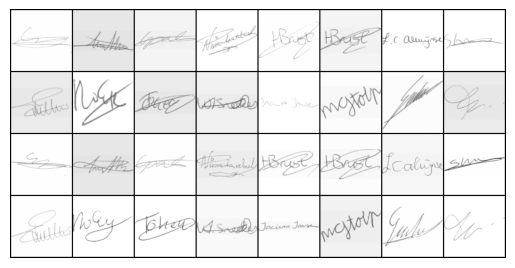

[[0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]]


In [12]:
# Viewing the sample of images and to check whether its loading properly
vis_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        batch_size=16)
dataiter = iter(vis_dataloader)

example_batch = next(dataiter)
concatenated = torch.cat((example_batch[0],example_batch[1]),0)
imshow(torchvision.utils.make_grid(concatenated))
print(example_batch[2].numpy())

In [13]:
import torch
import torch.nn as nn
from torchvision.models import resnet18, ResNet18_Weights


class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()

        # Custom model using ResNet-like backdone structure with manually specified parameters
        self.backbone = ResNet(
            block=BasicBlock,
            layers=[2, 2, 2, 2],
            num_classes=1000,
            zero_init_residual=False,
            groups=1,
            width_per_group=64,
            replace_stride_with_dilation=[False, False, False],
            norm_layer=nn.BatchNorm2d
        )
        self.backbone.fc = nn.Identity()  # Remove classification head

        # 64-dim projection head
        self.fc = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, 64)  #  Increase embedding size from 2 → 64
        )

    def forward_once(self, x):
        if x.shape[1] == 1:
            x = x.repeat(1, 3, 1, 1)  # Convert grayscale to 3-channel
        features = self.backbone(x)
        embedding = self.fc(features)
        return embedding


    # Defining forward
    def forward(self, input1, input2):
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        return output1, output2


In [14]:
class ContrastiveLoss(torch.nn.Module):

    def __init__(self, margin=1.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2)
        loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                      (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))


        return loss_contrastive

In [15]:
# Load the dataset as pytorch tensors using dataloader
train_dataloader = DataLoader(siamese_dataset, shuffle=True, batch_size=32, num_workers=0)

In [16]:
# Check whether you have GPU is loaded or not
if torch.cuda.is_available():
    print('Yes')
else:
    print('GPU not availble')

Yes


In [23]:
from torchvision.models.resnet import ResNet, BasicBlock

# Declare Siamese Network
net = SiameseNetwork().cuda()

# Declare Loss Function
criterion = ContrastiveLoss()

# Declare Optimizer
optimizer = torch.optim.Adam(net.parameters(), lr=1e-4, weight_decay=1e-5)

In [24]:
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
import torchvision
import torch.nn.functional as F
import torch
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import numpy as np

In [25]:
def train():
    counter = []
    loss_history = []
    iteration_number= 0

    for epoch in range(0,Config.train_number_epochs):
        for i, data in enumerate(train_dataloader,0):
            img0, img1 , label = data
            img0, img1 , label = img0.cuda(), img1.cuda() , label.cuda()
            optimizer.zero_grad()
            output1,output2 = net(img0,img1)
            loss_contrastive = criterion(output1,output2,label)
            loss_contrastive.backward()
            optimizer.step()
            if i %50 == 0 :
                print("Epoch number {}\n Current loss {}\n".format(epoch,loss_contrastive.item()))
                iteration_number +=10
                counter.append(iteration_number)
                loss_history.append(loss_contrastive.item())
    return net


In [26]:
# Setup device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Train the model
model = train()
torch.save(model.state_dict(), "model.pt")
print("Model Saved Successfully")

Epoch number 0
 Current loss 0.3153904676437378

Epoch number 0
 Current loss 0.23241709172725677

Epoch number 0
 Current loss 0.2594204545021057

Epoch number 0
 Current loss 0.24592110514640808

Epoch number 0
 Current loss 0.25148624181747437

Epoch number 0
 Current loss 0.23627573251724243

Epoch number 0
 Current loss 0.2539944052696228

Epoch number 0
 Current loss 0.25394463539123535

Epoch number 0
 Current loss 0.2545512616634369

Epoch number 0
 Current loss 0.27746903896331787

Epoch number 0
 Current loss 0.2456246316432953

Epoch number 0
 Current loss 0.25715118646621704

Epoch number 0
 Current loss 0.2502710819244385

Epoch number 0
 Current loss 0.2528975307941437

Epoch number 0
 Current loss 0.2560426592826843

Epoch number 1
 Current loss 0.2373039722442627

Epoch number 1
 Current loss 0.2528170645236969

Epoch number 1
 Current loss 0.24585631489753723

Epoch number 1
 Current loss 0.257864385843277

Epoch number 1
 Current loss 0.2471739649772644

Epoch number 

In [27]:
# TESTING
model = SiameseNetwork().to(device)

# Load model weights safely
state_dict = torch.load("model.pt", weights_only=True)
model.load_state_dict(state_dict)

<All keys matched successfully>

In [28]:
# Load the test dataset
test_dataset = SiameseNetworkDataset(training_csv=testing_csv, training_dir=testing_dir,
                                     transform=transforms.Compose([
                                         transforms.Resize((105, 105)),
                                         transforms.ToTensor()
                                     ]))
test_dataloader = DataLoader(test_dataset, num_workers=0, batch_size=1, shuffle=True)


Best Threshold: 0.11 | Accuracy: 66.05%


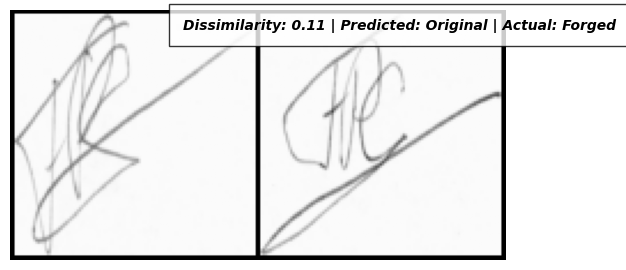

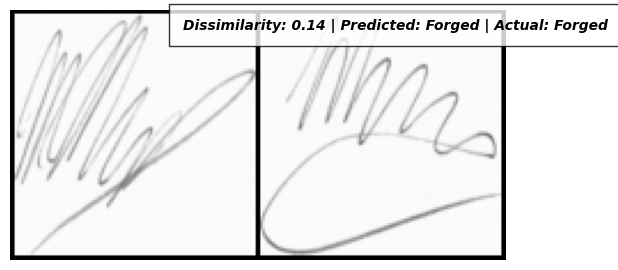

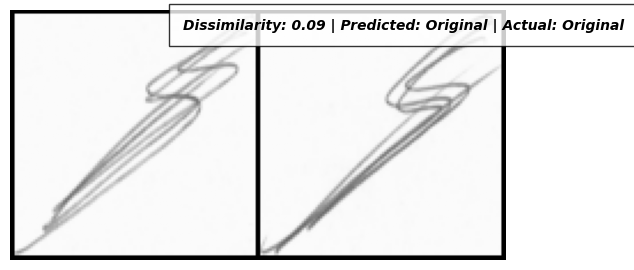

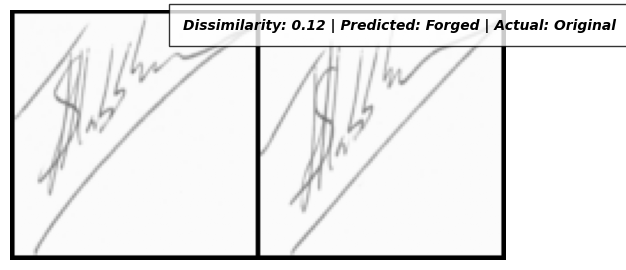

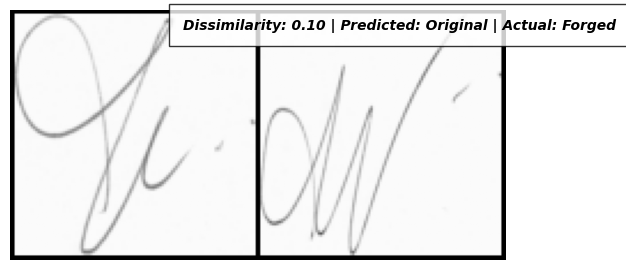

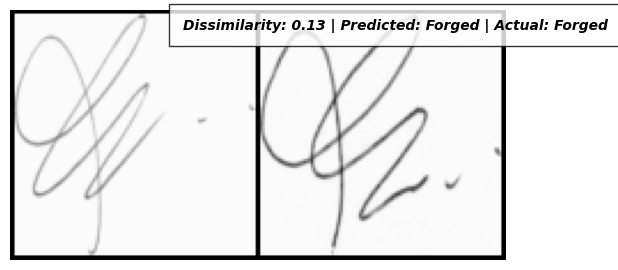

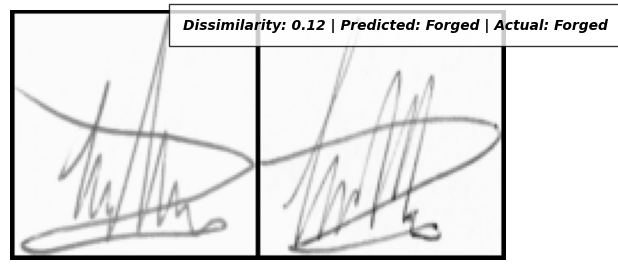

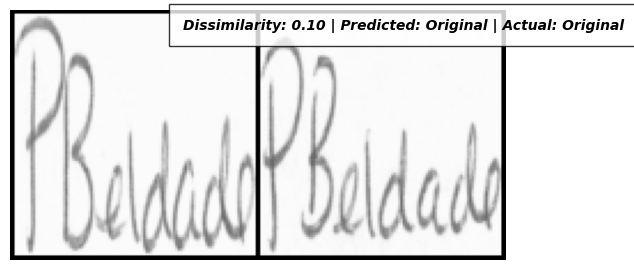

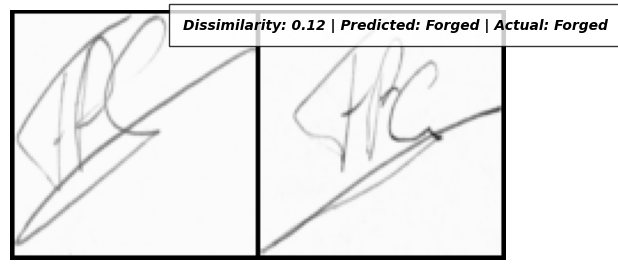

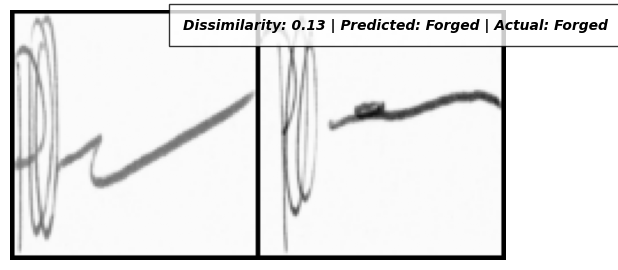

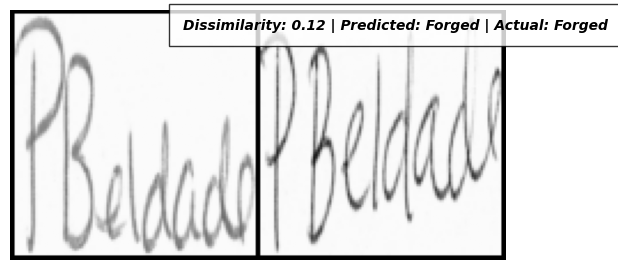

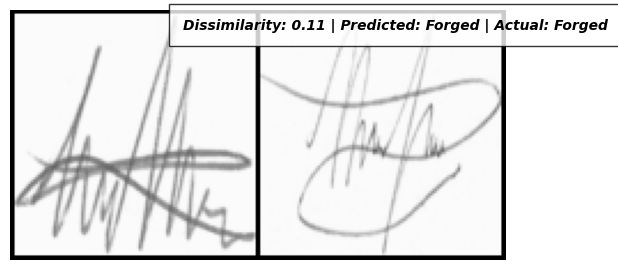

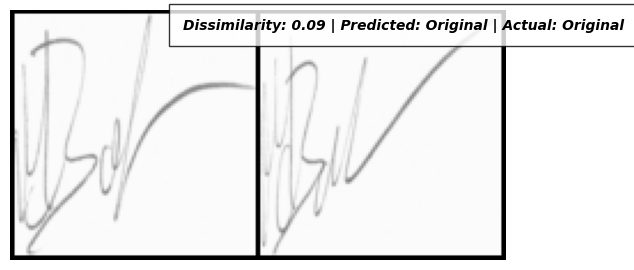

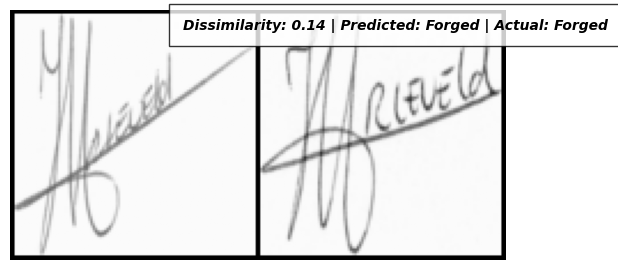

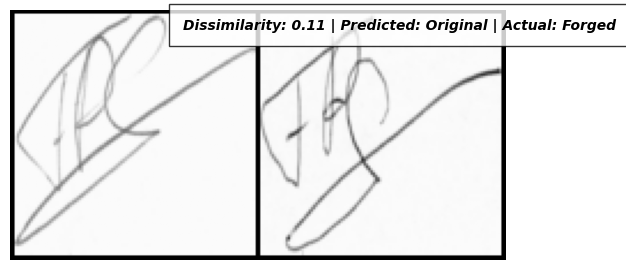

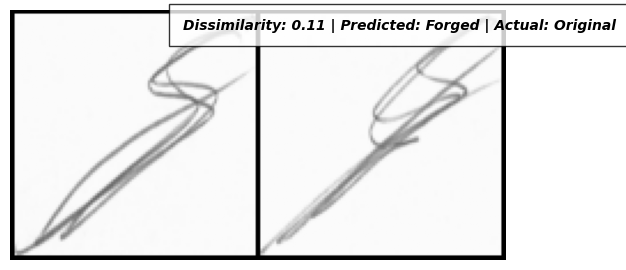

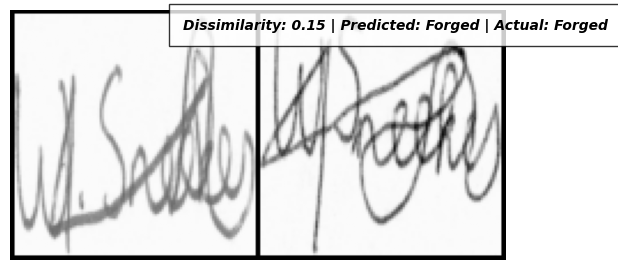

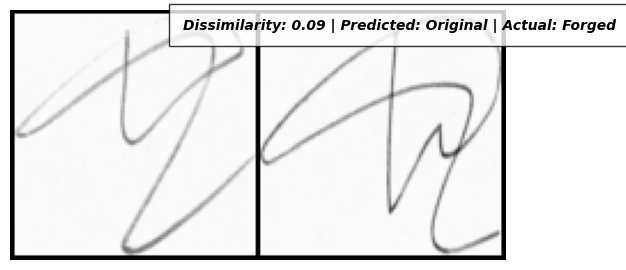

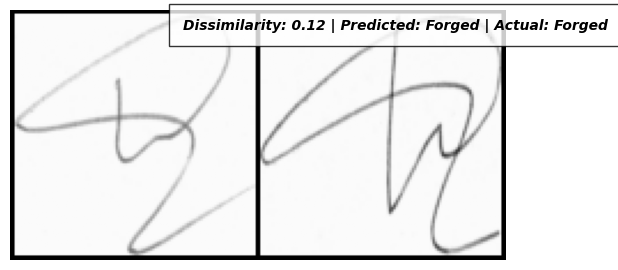

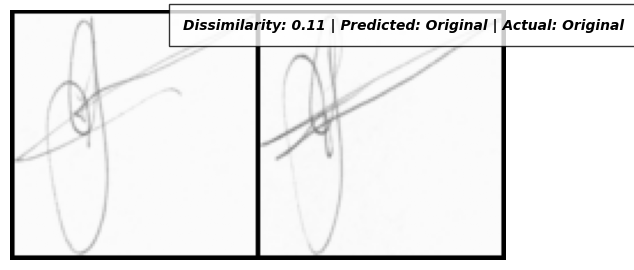

Final Test Accuracy: 70.00%


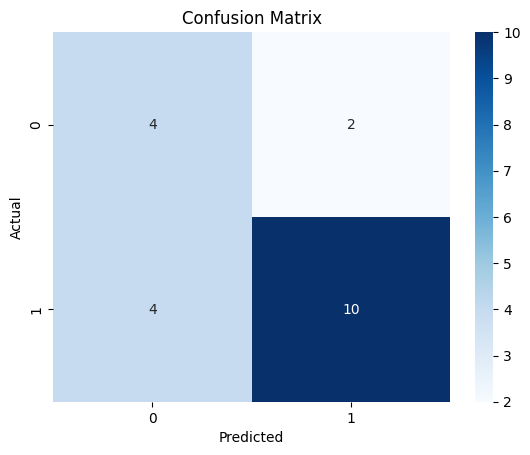

In [29]:
#STEP 1: Find best threshold first
def find_best_threshold(model, test_dataloader):
    model.eval()
    distances = []
    labels = []

    with torch.no_grad():
        for img1, img2, label in test_dataloader:
            img1, img2 = img1.to(device), img2.to(device)
            output1, output2 = model(img1, img2)
            dist = F.pairwise_distance(output1, output2).item()
            distances.append(dist)
            labels.append(int(label.item()))

    best_acc = 0
    best_thresh = 0
    for t in np.arange(0.01, 1.0, 0.01):
        preds = [1 if d > t else 0 for d in distances]
        correct = sum(int(p == l) for p, l in zip(preds, labels))
        acc = correct / len(labels)
        if acc > best_acc:
            best_acc = acc
            best_thresh = t

    print(f"Best Threshold: {best_thresh:.2f} | Accuracy: {best_acc * 100:.2f}%")
    return best_thresh

#STEP 2: Use that threshold to display predictions visually
best_threshold = find_best_threshold(model, test_dataloader)

# visualize
counter = 0
y_true = []
y_pred = []

with torch.no_grad():
    for i, data in enumerate(test_dataloader, 0):
        x0, x1, label = data
        concatenated = torch.cat((x0, x1), 0)

        output1, output2 = model(x0.to(device), x1.to(device))
        eucledian_distance = F.pairwise_distance(output1, output2).item()

        predicted_label = "Original" if eucledian_distance < best_threshold else "Forged"
        actual_label = "Original" if label.item() == 0 else "Forged"

        imshow(
            torchvision.utils.make_grid(concatenated),
            f'Dissimilarity: {eucledian_distance:.2f} | Predicted: {predicted_label} | Actual: {actual_label}'
        )

        y_true.append(0 if actual_label == "Original" else 1)
        y_pred.append(0 if predicted_label == "Original" else 1)

        counter += 1
        if counter == 20:
            break

# Test accuracy and confusion matrix
acc = accuracy_score(y_true, y_pred)
print(f"Final Test Accuracy: {acc * 100:.2f}%")

cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()
